## Imports

In [1]:
import os.path as osp
import random
from itertools import product

import numpy as np
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid, RandomPartitionGraphDataset
from torch_geometric.nn import (
    GCNConv, GATv2Conv, GATConv, SAGEConv, GINConv, TransformerConv
)

import matplotlib.pyplot as plt

C:\Users\sanna\anaconda3\envs\CSC413\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GNN Model and analysis

### Global variables and hyperparameters

In [2]:
# global variables
homophily_ratios = [round(0.1*x, 1) for x in range(1, 10)]
models = {}
epoch_train_lists = {}
epoch_val_lists = {}
epoch_test_lists = {}

# hyperparameters
args = {"num_datasets_per_ratio": 3,
        "num_nodes_per_class": 400,
        "average_degree": 10,
        "epochs": 300,
        "lr": 0.001,
        "weight_decay": 5e-4,
        "hidden_channels": 128,
        "layer": "GCNConv",  # GCNConv, SAGEConv, GATConv, GATv2Conv, TransformerConv
        "bias": True, 
        }

### Dataset Generation

In [3]:
# Fetching the cora dataset to get its features
path_real = osp.join("/mnt/nas2/GNN-DATA/PYG", Planetoid.__name__)
dataset_real = Planetoid(path_real, "Cora")
data_real = dataset_real[0]

path_syn = osp.join("/mnt/nas2/GNN-DATA/PYG", RandomPartitionGraphDataset.__name__)

################################# Dataset generation ###########################


def generate_datasets(K, average_degree, num_nodes_per_class, homophily_ratios):
    datasets = {}

    for node_homophily_ratio in homophily_ratios:
        data_syn_list = []
        for i in range(K):
            dataset_syn = RandomPartitionGraphDataset(
                path_syn,
                num_channels=dataset_real.num_features,
                num_classes=dataset_real.num_classes,
                num_nodes_per_class=num_nodes_per_class,
                node_homophily_ratio=node_homophily_ratio,
                average_degree=average_degree,
                # **kws,  # node_homophily_ratio=0.63, average_degree=3.90,
                transform=T.Compose([
                    T.RandomNodeSplit("random", num_splits=K),
                ]),
            )
            data_syn = dataset_syn[0]
            data_syn_list.append(data_syn)
        datasets[node_homophily_ratio] = data_syn_list
    
    return datasets

In [4]:
datasets = generate_datasets(args["num_datasets_per_ratio"], args["average_degree"], args["num_nodes_per_class"], homophily_ratios)

### Model Definition

In [5]:
class Net(torch.nn.Module):
    def __init__(self, args, bias=True):
        super().__init__()
        self.args = args

        hidden_channels=self.args["hidden_channels"]
        layer = self.args["layer"]
        _cls = eval(layer)
        if layer == "GCNConv" or layer == "SAGEConv":
            self.conv1 = _cls(dataset_real.num_features, hidden_channels, bias=bias)
            self.conv2 = _cls(hidden_channels, dataset_real.num_classes)
        elif layer == "GATConv" or layer == "TransformerConv" or layer == "GATv2Conv":
            self.conv1 = _cls(dataset_real.num_features, hidden_channels // 8, heads=8, bias=bias)
            self.conv2 = _cls(hidden_channels, dataset_real.num_classes, bias=bias)
        else:
            raise ValueError(f"Wrong layer: {layer}")
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.args["lr"], weight_decay=self.args["weight_decay"])
        

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        conv_layer_1 = self.conv1(x, edge_index, edge_attr)
        relu_layer = F.elu(conv_layer_1)
        drop_out_layer = F.dropout(relu_layer)
        conv_layer_2 = self.conv2(drop_out_layer, edge_index, edge_attr)
        return F.log_softmax(conv_layer_2, dim=1)
    

    def embed(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        return self.conv1(x, edge_index, edge_attr)

    def train_model(self, data, idx=None):
        self.train()

        if data.train_mask.dim() >= 2 and idx is not None:
            mask = data.train_mask[:, idx]
        else:
            mask = data.train_mask
        (F.nll_loss(self(data)[mask], data.y[mask]) / self.args["num_datasets_per_ratio"]).backward()

        if idx is None or idx == self.args["num_datasets_per_ratio"] - 1 or self.args["num_datasets_per_ratio"] == 1:
            self.optimizer.step()
            self.optimizer.zero_grad()


    @torch.no_grad()
    def test(self, data, idx=None):
        self.eval()
        log_probs, accs = self(data), []
        for _, mask in data("train_mask", "val_mask", "test_mask"):

            if mask.dim() >= 2 and idx is not None:
                mask = mask[:, idx]

            pred = log_probs[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs


    @torch.no_grad()
    def logistic_regression_test(self, data, h_type):
        reg = LogisticRegression()
        self.eval()
        if h_type == "x":
            h = data.x.cpu()
        elif h_type == "h1":
            h = self.embed(data).cpu()
        elif h_type == "h2":
            h = self(data_real).cpu()
        else:
            raise ValueError(f"Wrong type: {h_type}")

        y = data.y.cpu()
        reg.fit(h[data.train_mask].numpy(),
                y[data.train_mask].numpy())
        lr_test_acc = reg.score(h[data.test_mask].numpy(),
                                y[data.test_mask].numpy())
        return lr_test_acc

    def fit(self, data_syn_list, verbose=True):
        epoch_train_list, epoch_val_list, epoch_test_list = [], [], []

        for epoch in range(self.args["epochs"]):
            random.shuffle(data_syn_list)

            train_list, val_list, test_list = [], [], []
            
            for data_syn in data_syn_list:
                self.train_model(data_syn, idx=epoch % self.args["num_datasets_per_ratio"])

                train_acc, val_acc, test_acc = self.test(data_syn, idx=epoch % self.args["num_datasets_per_ratio"])
                train_list.append(train_acc)
                val_list.append(val_acc)
                test_list.append(test_acc)

            epoch_train_list.append(np.mean(train_list)) # per epoch, avg train acc
            epoch_val_list.append(np.mean(val_list)) # per epoch, avg val acc
            epoch_test_list.append(np.mean(test_list)) # per epoch, avg test acc

            if epoch % 10 == 0 and verbose:
                print(
                    f"{self.args['layer']} | "
                    f"Epoch: {epoch:03d}, "
                    f"Train: {np.mean(train_list):.4f}, "
                    f"Val: {np.mean(val_list):.4f}, "
                    f"Test: {np.mean(test_list):.4f}, "
                    f'LRT X: {self.logistic_regression_test(data_real, "x"):.4f}, '
                    f'LRT H1: {self.logistic_regression_test(data_real, "h1"):.4f}, '
                    f'LRT H2: {self.logistic_regression_test(data_real, "h2"):.4f}'
                )

        return epoch_train_list, epoch_val_list, epoch_test_list
        

### Model Training and Evalutions

#### Training

In [ ]:
for ratio in homophily_ratios:
    print("======= Starting training for homophily =", ratio, "===============")
    model = Net(args)
    epoch_train_list, epoch_val_list, epoch_test_list = model.fit(data_syn_list=datasets[ratio])
    models[ratio] = model
    epoch_train_lists[ratio], epoch_val_lists[ratio], epoch_test_lists[ratio] = epoch_train_list, epoch_val_list, epoch_test_list
    print("======= Ended training for homophily =", ratio, "===============")

In [ ]:
# ratio = 0.9
# print("======= Starting training for homophily =", ratio, "===============")
# model = Net(args)
# epoch_train_list, epoch_val_list, epoch_test_list = model.fit(data_syn_list=datasets[ratio])
# models[ratio] = model
# epoch_train_lists[ratio], epoch_val_lists[ratio], epoch_test_lists[ratio] = epoch_train_list, epoch_val_list, epoch_test_list
# print("======= Ended training for homophily =", ratio, "===============")

In [8]:
GCN_300 = {
    "models": models,
    "epoch_train_lists": epoch_train_lists,
    "epoch_val_lists": epoch_val_lists,
    "epoch_test_lists": epoch_test_lists,
    "args": args,
    "datasets": datasets
}

In [9]:
import pickle
with open("./results/GCN_300_2022-04-24-10:50pm", "wb") as outfile:
    pickle.dump(GCN_300, outfile)

#### Evaluations

##### Plotting graphs

In [ ]:
def training_plot(train_accuracy, validation_accuracy, homophily_ratio):
    """Saves a plot of the training and validation loss curves."""
    plt.figure()
    plt.plot(range(len(train_accuracy)), train_accuracy)
    plt.plot(range(len(validation_accuracy)), validation_accuracy)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"./training_plots/h_{homophily_ratio}_epoch_accuracy.png")

In [18]:
# Saving the plot of all validation accuracies of models made on different homophily ratios
def plot_accuracies_by_homophilies(accuracies: dict, homophily_ratios: list, filename: str):
  plt.figure(figsize=(10, 5))
  for ratio in homophily_ratios:
 
    accuracy = accuracies[ratio]
    plt.plot(range(len(accuracy)), accuracy, label=f"h={ratio}")
    plt.legend()

  plt.xlabel("Epochs", fontsize=16)
  plt.ylabel("Accuracy", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend()
  # plt.tight_layout()
  plt.savefig(filename)

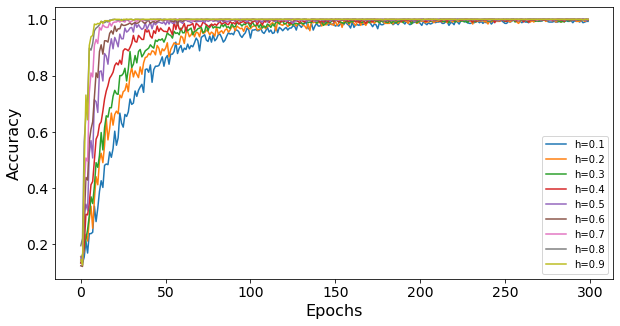

In [21]:
# Training accuracies over epochs
plot_accuracies_by_homophilies(epoch_train_lists, homophily_ratios, "./plots/epoch_train_accuracies_GCN_300.jpg")

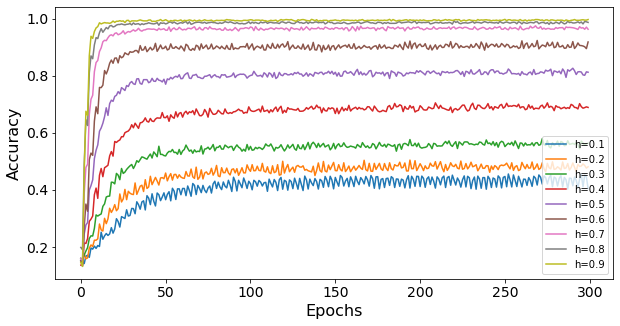

In [23]:
# Validation accuracies over epochs
plot_accuracies_by_homophilies(epoch_val_lists, homophily_ratios, "./plots/epoch_val_accuracies_GCN_300.jpg")

##### Embedding similarity analysis

In [24]:
def conv2_embed(model, data):
    x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
    conv_layer_1 = model.conv1(x, edge_index, edge_attr)
    relu_layer = F.elu(conv_layer_1)
    conv_layer_2 = model.conv2(relu_layer, edge_index, edge_attr)
    return conv_layer_2

In [28]:
def average_similarity(model, dataset, node_class=0, layer=1, args=args):

    embeddings =  conv2_embed(model, dataset) if layer == 2 else model.embed(dataset)

    avg_sim = 0
    observations = 0
    for i in range( args["num_nodes_per_class"] * node_class, 
                    args["num_nodes_per_class"] * (node_class + 1)
                ):
        for j in range( i + 1, 
                        args["num_nodes_per_class"] * (node_class + 1)
                    ):
            
            x1 = embeddings[i].detach().numpy()
            x2 = embeddings[j].detach().numpy()

            y1 = dataset.y.numpy()[i]
            y2 = dataset.y.numpy()[j]

            assert(y1 != y2)

            avg_sim += np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
            observations += 1

    avg_sim /= observations

    return avg_sim

avg_sims = []
for ratio in homophily_ratios:

    model = models[ratio]
    dataset = datasets[ratio][0]
    avg_sim = average_similarity(model, dataset, node_class=0, layer=1)

    avg_sims.append(avg_sim)

    print(f"Ratio: {ratio} \t Avg in class similarity: {avg_sim}")



Ratio: 0.1 	 Avg in class similarity: 0.04044224869291866
Ratio: 0.2 	 Avg in class similarity: 0.03504110135268722
Ratio: 0.3 	 Avg in class similarity: 0.05645930444915316
Ratio: 0.4 	 Avg in class similarity: 0.06527180216282662
Ratio: 0.5 	 Avg in class similarity: 0.07864306184751366
Ratio: 0.6 	 Avg in class similarity: 0.08678048250050986
Ratio: 0.7 	 Avg in class similarity: 0.1441894640618735
Ratio: 0.8 	 Avg in class similarity: 0.21253088619648292
Ratio: 0.9 	 Avg in class similarity: 0.1868969668794733


In [78]:
def average_similarity(model, dataset, per_class=10, layer=1, args=args):

    embeddings =  conv2_embed(model, dataset) if layer == 2 else model.embed(dataset)

    to_compare = []

    for i in range(7):
        base = args["num_nodes_per_class"] * i
        for pick in range(base, base + per_class):
            to_compare.append(pick)

    avg_sim = 0
    observations = 0
    for i in range( args["num_nodes_per_class"] * 7):
        for j in to_compare:

            if i != j:
            
                x1 = embeddings[i].detach().numpy()
                x2 = embeddings[j].detach().numpy()

                avg_sim += np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
                observations += 1

    avg_sim /= observations

    return avg_sim

avg_sims_across = []
for ratio in homophily_ratios:

    model = models[ratio]
    dataset = datasets[ratio][0]
    avg_sim = average_similarity(model, dataset, node_class=0, layer=1)

    avg_sims_across.append(avg_sim)

    print(f"Ratio: {ratio} \t Avg similarity across: {avg_sim}")



[0.044615121134272066,
 0.029284557667007678,
 0.03159307844522246,
 0.017639194496740618,
 0.013030776060867777,
 0.01045465865311207,
 0.008169484457425264,
 0.007755561022945483,
 0.02418918383404142]

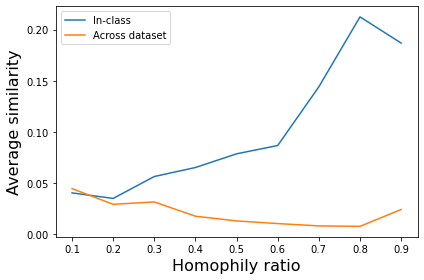

In [84]:
plt.figure()
plt.plot(homophily_ratios, avg_sims, label="In-class")
plt.plot(homophily_ratios, avg_sims_across, label="Across dataset")

plt.xlabel("Homophily ratio", fontsize=16)
plt.ylabel("Average similarity", fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("./plots/average_similarities.jpg")

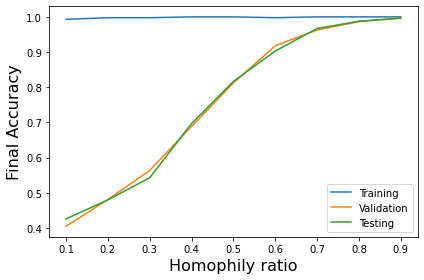

In [82]:
plt.figure()
plt.plot(homophily_ratios, [epoch_train_lists[i][-1] for i in homophily_ratios], label="Training")
plt.plot(homophily_ratios, [epoch_val_lists[i][-1] for i in homophily_ratios], label="Validation")
plt.plot(homophily_ratios, [epoch_test_lists[i][-1] for i in homophily_ratios], label="Testing")


plt.xlabel("Homophily ratio", fontsize=16)
plt.ylabel("Final Accuracy", fontsize=16)
plt.legend()

plt.tight_layout()
plt.savefig("./plots/final_accuracies.jpg")

### Model loading from pickles

In [77]:
import pickle
with open("./results/GCN_300_final", "rb") as infile:
    GCN_300 = pickle.load(infile)


In [ ]:
models = GCN_300["models"]
epoch_train_lists = GCN_300["epoch_train_lists"]
epoch_val_lists = GCN_300["epoch_val_lists"]
epoch_test_lists = GCN_300["epoch_test_lists"]
args = GCN_300["args"]
datasets = GCN_300["datasets"]